<a href="https://colab.research.google.com/github/vibferreira/DL_UBS/blob/main/DeepNetsForEO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Semantic segmentation of aerial images with deep networks

This notebook presents a straightforward PyTorch implementation of a Fully Convolutional Network for semantic segmentation of aerial images. More specifically, we aim to automatically perform scene interpretation of images taken from a plane or a satellite by classifying every pixel into several land cover classes.

As a demonstration, we are going to use the [SegNet architecture](http://mi.eng.cam.ac.uk/projects/segnet/) to segment aerial images over the cities of Vaihingen and Potsdam. The images are from the [ISPRS 2D Semantic Labeling dataset](http://www2.isprs.org/commissions/comm3/wg4/results.html). We will train a network to segment roads, buildings, vegetation and cars.

This work is a PyTorch implementation of the baseline presented in "[Beyond RGB: Very High Resolution Urban Remote Sensing With Multimodal Deep Networks](https://hal.archives-ouvertes.fr/hal-01636145) ", Nicolas Audebert, Bertrand Le Saux and Sébastien Lefèvre, ISPRS Journal, 2018.

The original code for this notebook is the [DeepNetsForEO](https://github.com/nshaud/DeepNetsForEO) repository.


## GPU

Enable GPU with `Runtime->Change runtime type->Hardware Accelerator->GPU` in the top menu

In [1]:
%%capture
!pip install rasterio

In [20]:
# imports and stuff
import numpy as np
from skimage import io
from glob import glob
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import confusion_matrix
import random
import itertools
from skimage.io import imread
import os
import pathlib
import gdal
import rasterio
from PIL import Image

# Matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
# Torch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
import torch.optim.lr_scheduler
import torch.nn.init
from torch.autograd import Variable
from torchvision.transforms import ToTensor
from torchvision.transforms import transforms


In [3]:
# mount your google drive (follow the link, allow what is needed and get the authorization code)
from google.colab import drive
drive.mount('/content/gdrive/')

import sys

!unzip "/content/gdrive/MyDrive/vitoria.barbosa.ferreira@usp.br 2021-08-09 21:44/Master/Copernicus - 15 01/Classes/3 semester/Computer Vision/Image Analysis/JURSE.zip"
# data are assumed to be in Vaihingen/ directory, otherwise modify accordingly
FOLDER = '/content/JURSE/'
sys.path.append(FOLDER)

Mounted at /content/gdrive/
Archive:  /content/gdrive/MyDrive/vitoria.barbosa.ferreira@usp.br 2021-08-09 21:44/Master/Copernicus - 15 01/Classes/3 semester/Computer Vision/Image Analysis/JURSE.zip
  inflating: JURSE/Vaihingen/top/top_mosaic_09cm_area1.tif  
  inflating: JURSE/Vaihingen/gts_eroded_for_participants/top_mosaic_09cm_area23_noBoundary.tif  
  inflating: JURSE/Vaihingen/top/top_mosaic_09cm_area23.tif  
  inflating: JURSE/Vaihingen/gts_eroded_for_participants/top_mosaic_09cm_area1_noBoundary.tif  
  inflating: JURSE/Vaihingen/gts_for_participants/top_mosaic_09cm_area23.tif  
  inflating: JURSE/Vaihingen/gts_for_participants/top_mosaic_09cm_area1.tif  
  inflating: JURSE/Vaihingen/gts_for_participants/top_mosaic_09cm_area5.tif  
  inflating: JURSE/Vaihingen/top/top_mosaic_09cm_area5.tif  
  inflating: JURSE/Vaihingen/gts_eroded_for_participants/top_mosaic_09cm_area5_noBoundary.tif  
  inflating: JURSE/Models/segnet_final_reference.pth  
  inflating: JURSE/Models/vgg16_bn-6c64b

In [4]:
# project_path = '/content'
# !curl -k https://files.inria.fr/aerialimagelabeling/getAerial.sh | bash # too heavy
# !git clone https://github.com/dronedeploy/dd-ml-segmentation-benchmark.git # dataset not longer available
# !unzip {project_path}/EuroSAT.zip -d {project_path} # classification not segmentation task


# Parameters

There are several parameters than can be tuned to use this notebook with different datasets. The default parameters are suitable for the ISPRS dataset, but you can change them to work with your data.

## Examples

*   Binary classification: N_CLASSES = 2
*   Multi-spectral data (e.g. IRRGB): IN_CHANNELS = 4
*  New folder naming convention : DATA_FOLDER = MAIN_FOLDER + 'sentinel2/sentinel2_img_{}.tif'


In [5]:
# Parameters++++
WINDOW_SIZE = (256, 256) # Patch size
STRIDE = 32 # Stride for testing
IN_CHANNELS = 3 # Number of input channels (e.g. RGB)
##FOLDER = "./ISPRS_dataset/" # Replace with your "/path/to/the/ISPRS/dataset/folder/"
BATCH_SIZE = 5 # Number of samples in a mini-batch

LABELS = ["roads", "buildings", "low veg.", "trees", "cars", "clutter"] # Label names
N_CLASSES = len(LABELS) # Number of classes
WEIGHTS = torch.ones(N_CLASSES) # Weights for class balancing
CACHE = True # Store the dataset in-memory

DATASET = 'Vaihingen'
# FOLDER = FOLDER[:-10]
if DATASET == 'Potsdam':
    MAIN_FOLDER = FOLDER + 'Potsdam/'
    # Uncomment the next line for IRRG data
    # DATA_FOLDER = MAIN_FOLDER + '3_Ortho_IRRG/top_potsdam_{}_IRRG.tif'
    # For RGB data
    DATA_FOLDER = MAIN_FOLDER + '2_Ortho_RGB/top_potsdam_{}_RGB.tif'
    LABEL_FOLDER = MAIN_FOLDER + '5_Labels_for_participants/top_potsdam_{}_label.tif'
    ERODED_FOLDER = MAIN_FOLDER + '5_Labels_for_participants_no_Boundary/top_potsdam_{}_label_noBoundary.tif'    
elif DATASET == 'Vaihingen':
    MAIN_FOLDER = FOLDER + 'Vaihingen/'
    DATA_FOLDER = MAIN_FOLDER + 'top/top_mosaic_09cm_area{}.tif'
    LABEL_FOLDER = MAIN_FOLDER + 'gts_for_participants/top_mosaic_09cm_area{}.tif'
    ERODED_FOLDER = MAIN_FOLDER + 'gts_eroded_for_participants/top_mosaic_09cm_area{}_noBoundary.tif'


In [6]:
# Parameters++++
WINDOW_SIZE = (256, 256) # Patch size
STRIDE = 32 # Stride for testing
IN_CHANNELS = 3 # Number of input channels (e.g. RGB)
##FOLDER = "./ISPRS_dataset/" # Replace with your "/path/to/the/ISPRS/dataset/folder/"
BATCH_SIZE = 5 # Number of samples in a mini-batch

LABELS = ["buildings", "no_buildings"] # Label names
N_CLASSES = len(LABELS) # Number of classes
WEIGHTS = torch.ones(N_CLASSES) # Weights for class balancing
CACHE = True # Store the dataset in-memory

FOLDER = '/content/gdrive/MyDrive/vitoria.barbosa.ferreira@usp.br 2021-08-09 21:44/Master/Copernicus - 15 01/Classes/3 semester/Computer Vision/Image Analysis/aerial_image_labelling'
sys.path.append(FOLDER)

DATA_FOLDER = os.path.join(FOLDER, 'imgs/')
LABEL_FOLDER = os.path.join(FOLDER, 'label/')
# list(pathlib.Path(path).glob('*.tiff'))


# Visualizing the dataset

First, let's check that we are able to access the dataset and see what's going on. We use scikit-image for image manipulation.

As the ISPRS dataset is stored with a ground truth in the RGB format, we need to define the color palette that can map the label id to its RGB color. We define two helper functions to convert from numeric to colors and vice-versa.


/content/JURSE/Vaihingen/top/top_mosaic_09cm_area1.tif
(2569, 1919, 3)


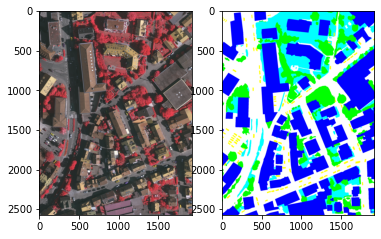

Ground truth in numerical format has shape (2569,1919) : 
 [[0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 ...
 [1 1 1 ... 4 4 4]
 [1 1 1 ... 4 4 4]
 [1 1 1 ... 0 0 0]]


In [7]:
# ISPRS color palette
# Let's define the standard ISPRS color palette
palette = {0 : (255, 255, 255), # Impervious surfaces (white)
           1 : (0, 0, 255),     # Buildings (blue)
           2 : (0, 255, 255),   # Low vegetation (cyan)
           3 : (0, 255, 0),     # Trees (green)
           4 : (255, 255, 0),   # Cars (yellow)
           5 : (255, 0, 0),     # Clutter (red)
           6 : (0, 0, 0)}       # Undefined (black)

invert_palette = {v: k for k, v in palette.items()}

def convert_to_color(arr_2d, palette=palette):
    """ Numeric labels to RGB-color encoding """
    arr_3d = np.zeros((arr_2d.shape[0], arr_2d.shape[1], 3), dtype=np.uint8)

    for c, i in palette.items():
        m = arr_2d == c
        arr_3d[m] = i

    return arr_3d

def convert_from_color(arr_3d, palette=invert_palette):
    """ RGB-color encoding to grayscale labels """
    arr_2d = np.zeros((arr_3d.shape[0], arr_3d.shape[1]), dtype=np.uint8)

    for c, i in palette.items():
        m = np.all(arr_3d == np.array(c).reshape(1, 1, 3), axis=2)
        arr_2d[m] = i

    return arr_2d

# We load one tile from the dataset and we display it
print(MAIN_FOLDER+'top/top_mosaic_09cm_area1.tif')
      
img = io.imread(MAIN_FOLDER+'/top/top_mosaic_09cm_area1.tif')
fig = plt.figure()
fig.add_subplot(121)

print(img.shape)
plt.imshow(img);##img)

# We load the ground truth
gt = io.imread(MAIN_FOLDER+'gts_for_participants/top_mosaic_09cm_area1.tif')
fig.add_subplot(122)
plt.imshow(gt)
plt.show()

# We also check that we can convert the ground truth into an array format
array_gt = convert_from_color(gt)
print("Ground truth in numerical format has shape ({},{}) : \n".format(*array_gt.shape[:2]), array_gt)

(5000, 5000, 3)


<Figure size 432x288 with 0 Axes>

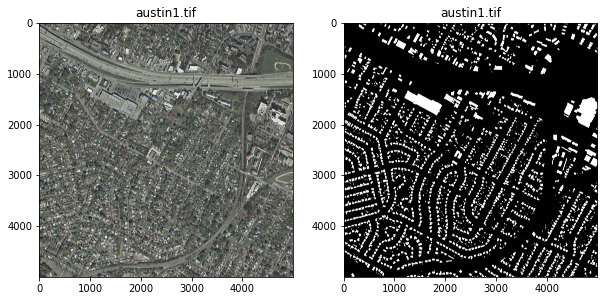

In [34]:
# We load one tile from the dataset and we display it

def get_title(img):
  return str(img).split('/')[-1]

# List of Files 
imgs_folder = sorted(glob(DATA_FOLDER + '/*.tif'))
mask_folder = sorted(glob(LABEL_FOLDER + '/*.tif'))

# Plots

# RGB
plt.gray() 
fig, ax = plt.subplots(ncols= 2, figsize=(10,20))       
img = io.imread(imgs_folder[0])
print(img.shape)
ax[0].imshow(img)
ax[0].set_title(get_title(imgs[0]))

# Ground truth
array_gt = gdal.Open(str(labels[0])).ReadAsArray()
# array_gt = io.imread(labels[0])
ax[1].imshow(array_gt)
ax[1].set_title(get_title(mask_folder[0]))
plt.show()


In [29]:
class Aerial_Image_Dataset(torch.utils.data.Dataset):
  def __init__(self, data_paths, label_paths, transform=None):

    self.transform = transform
    self.data_p = []

    # List of files 
    self.data_paths = data_paths
    self.label_paths = label_paths

  def __len__(self):
    return len(self.data_paths)

  def __getitem__(self, idx):
    # images
    image = Image.open(self.data_paths[idx])
    image = ToTensor()(image) # Data Normalisation

    # labels 
    mask = Image.open(self.label_paths[idx])
    mask = ToTensor()(mask) # Data Normalisation

    # Get a random patch
    x1, x2, y1, y2 = get_random_pos(image, WINDOW_SIZE)
    data_p  = image[:, x1:x2,y1:y2]
    label_p = mask[x1:x2,y1:y2]

    # Augmentation
    if self.transform:
      data_p = self.transform(data_p)
      label_p = self.transform(label_p)

    return data_p, label_p

  # def len_dataset(self):
  #   return self.data_p

transforms = transforms.Compose([transforms.RandomHorizontalFlip(p=0.5),
                                 transforms.RandomVerticalFlip(p=0.5)])

dataset = Aerial_Image_Dataset(imgs_folder, mask_folder, transform=transforms)
len(dataset)

3

In [21]:
dataset = Aerial_Image_Dataset(imgs_folder, mask_folder, transform=transforms)
dataloader = torch.utils.data.DataLoader(dataset,batch_size=BATCH_SIZE)
# len(dataset)

In [33]:
a = dataset.__getitem__(0)


AttributeError: ignored

In [30]:
b = dataset.len_dataset()
b

[]

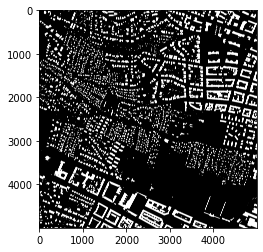

In [131]:
for i in range(len(dataset)):
    sample = dataset[i]

plt.Figure()
plt.imshow(sample[0].T)
plt.imshow(torch.squeeze(sample[1]))
plt.show()

In [23]:
#@title Utils

def get_random_pos(img, window_shape):
    """ Extract of 2D random patch of shape window_shape in the image """
    w, h = window_shape
    W, H = img.shape[-2:]
    x1 = random.randint(0, W - w - 1)
    x2 = x1 + w
    y1 = random.randint(0, H - h - 1)
    y2 = y1 + h
    return x1, x2, y1, y2

def CrossEntropy2d(input, target, weight=None, size_average=True):
    """ 2D version of the cross entropy loss """
    dim = input.dim()
    if dim == 2:
        return F.cross_entropy(input, target, weight, size_average)
##        return nn.CrossEntropyLoss(output, target,weight)
    elif dim == 4:
        output = input.view(input.size(0),input.size(1), -1)
        output = torch.transpose(output,1,2).contiguous()
        output = output.view(-1,output.size(2))
        target = target.view(-1)
        return F.cross_entropy(output, target,weight, size_average)
##        return nn.CrossEntropyLoss(output, target,weight)
    else:
        raise ValueError('Expected 2 or 4 dimensions (got {})'.format(dim))

def accuracy(input, target):
    return 100 * float(np.count_nonzero(input == target)) / target.size

def sliding_window(top, step=10, window_size=(20,20)):
    """ Slide a window_shape window across the image with a stride of step """
    for x in range(0, top.shape[0], step):
        if x + window_size[0] > top.shape[0]:
            x = top.shape[0] - window_size[0]
        for y in range(0, top.shape[1], step):
            if y + window_size[1] > top.shape[1]:
                y = top.shape[1] - window_size[1]
            yield x, y, window_size[0], window_size[1]
            
def count_sliding_window(top, step=10, window_size=(20,20)):
    """ Count the number of windows in an image """
    c = 0
    for x in range(0, top.shape[0], step):
        if x + window_size[0] > top.shape[0]:
            x = top.shape[0] - window_size[0]
        for y in range(0, top.shape[1], step):
            if y + window_size[1] > top.shape[1]:
                y = top.shape[1] - window_size[1]
            c += 1
    return c

def grouper(n, iterable):
    """ Browse an iterator by chunk of n elements """
    it = iter(iterable)
    while True:
        chunk = tuple(itertools.islice(it, n))
        if not chunk:
            return
        yield chunk

def metrics(predictions, gts, label_values=LABELS):
    cm = confusion_matrix(
            gts,
            predictions,
            range(len(label_values)))
    
    print("Confusion matrix :")
    print(cm)
    
    print("---")
    
    # Compute global accuracy
    total = sum(sum(cm))
    accuracy = sum([cm[x][x] for x in range(len(cm))])
    accuracy *= 100 / float(total)
    print("{} pixels processed".format(total))
    print("Total accuracy : {}%".format(accuracy))
    
    print("---")
    
    # Compute F1 score
    F1Score = np.zeros(len(label_values))
    for i in range(len(label_values)):
        try:
            F1Score[i] = 2. * cm[i,i] / (np.sum(cm[i,:]) + np.sum(cm[:,i]))
        except:
            # Ignore exception if there is no element in class i for test set
            pass
    print("F1Score :")
    for l_id, score in enumerate(F1Score):
        print("{}: {}".format(label_values[l_id], score))

    print("---")
        
    # Compute kappa coefficient
    total = np.sum(cm)
    pa = np.trace(cm) / float(total)
    pe = np.sum(np.sum(cm, axis=0) * np.sum(cm, axis=1)) / float(total*total)
    kappa = (pa - pe) / (1 - pe);
    print("Kappa: " + str(kappa))
    return accuracy

In [34]:

class ISPRS_dataset(torch.utils.data.Dataset):
    def __init__(self, ids, data_files=DATA_FOLDER, label_files=LABEL_FOLDER,
                            cache=False, augmentation=True):
        super(ISPRS_dataset, self).__init__()
        
        self.augmentation = augmentation
        self.cache = cache
        
        # List of files
        self.data_files = [DATA_FOLDER.format(id) for id in ids]
        self.label_files = [LABEL_FOLDER.format(id) for id in ids]

        # Sanity check : raise an error if some files do not exist
        for f in self.data_files + self.label_files:
            if not os.path.isfile(f):
                raise KeyError('{} is not a file !'.format(f))
        
        # Initialize cache dicts
        self.data_cache_ = {}
        self.label_cache_ = {}
            
    
    def __len__(self):
        # Default epoch size is 10 000 samples
        return 10000
    
    @classmethod
    def data_augmentation(cls, *arrays, flip=True, mirror=True):
        will_flip, will_mirror = False, False
        if flip and random.random() < 0.5:
            will_flip = True
        if mirror and random.random() < 0.5:
            will_mirror = True
        
        results = []
        for array in arrays:
            if will_flip:
                if len(array.shape) == 2:
                    array = array[::-1, :]
                else:
                    array = array[:, ::-1, :]
            if will_mirror:
                if len(array.shape) == 2:
                    array = array[:, ::-1]
                else:
                    array = array[:, :, ::-1]
            results.append(np.copy(array))
            
        return tuple(results)
    
    def __getitem__(self, i):
        # Pick a random image
        random_idx = random.randint(0, len(self.data_files) - 1)
        
        # If the tile hasn't been loaded yet, put in cache
        if random_idx in self.data_cache_.keys():
            data = self.data_cache_[random_idx]
        else:
            # Data is normalized in [0, 1]
            data = 1/255 * np.asarray(io.imread(self.data_files[random_idx]).transpose((2,0,1)), dtype='float32')
            if self.cache:
                self.data_cache_[random_idx] = data
            
        if random_idx in self.label_cache_.keys():
            label = self.label_cache_[random_idx]
        else: 
            # Labels are converted from RGB to their numeric values
            label = np.asarray(convert_from_color(io.imread(self.label_files[random_idx])), dtype='int64')
            if self.cache:
                self.label_cache_[random_idx] = label

        # Get a random patch
        x1, x2, y1, y2 = get_random_pos(data, WINDOW_SIZE)
        data_p = data[:, x1:x2,y1:y2]
        label_p = label[x1:x2,y1:y2]
        
        # Data augmentation
        data_p, label_p = self.data_augmentation(data_p, label_p)

        # Return the torch.Tensor values
        return (torch.from_numpy(data_p),
                torch.from_numpy(label_p))


We need to define a bunch of utils functions.


# Loading the dataset

We define a PyTorch dataset (`torch.utils.data.Dataset)` that loads all the tiles in memory and performs random sampling. Tiles are stored in memory on the fly.

The dataset also performs random data augmentation (horizontal and vertical flips) and normalizes the data in [0, 1].

In [139]:
# Dataset class

class ISPRS_dataset(torch.utils.data.Dataset):
    def __init__(self, ids, data_files=DATA_FOLDER, label_files=LABEL_FOLDER,
                            cache=False, augmentation=True):
        super(ISPRS_dataset, self).__init__()
        
        self.augmentation = augmentation
        self.cache = cache
        
        # List of files
        self.data_files = [DATA_FOLDER.format(id) for id in ids]
        self.label_files = [LABEL_FOLDER.format(id) for id in ids]

        # Sanity check : raise an error if some files do not exist
        for f in self.data_files + self.label_files:
            if not os.path.isfile(f):
                raise KeyError('{} is not a file !'.format(f))
        
        # Initialize cache dicts
        self.data_cache_ = {}
        self.label_cache_ = {}
            
    
    def __len__(self):
        # Default epoch size is 10 000 samples
        return 10000
    
    @classmethod
    def data_augmentation(cls, *arrays, flip=True, mirror=True):
        will_flip, will_mirror = False, False
        if flip and random.random() < 0.5:
            will_flip = True
        if mirror and random.random() < 0.5:
            will_mirror = True
        
        results = []
        for array in arrays:
            if will_flip:
                if len(array.shape) == 2:
                    array = array[::-1, :]
                else:
                    array = array[:, ::-1, :]
            if will_mirror:
                if len(array.shape) == 2:
                    array = array[:, ::-1]
                else:
                    array = array[:, :, ::-1]
            results.append(np.copy(array))
            
        return tuple(results)
    
    def __getitem__(self, i):
        # Pick a random image
        random_idx = random.randint(0, len(self.data_files) - 1)
        
        # If the tile hasn't been loaded yet, put in cache
        if random_idx in self.data_cache_.keys():
            data = self.data_cache_[random_idx]
        else:
            # Data is normalized in [0, 1]
            data = 1/255 * np.asarray(io.imread(self.data_files[random_idx]).transpose((2,0,1)), dtype='float32')
            if self.cache:
                self.data_cache_[random_idx] = data
            
        if random_idx in self.label_cache_.keys():
            label = self.label_cache_[random_idx]
        else: 
            # Labels are converted from RGB to their numeric values
            label = np.asarray(convert_from_color(io.imread(self.label_files[random_idx])), dtype='int64')
            if self.cache:
                self.label_cache_[random_idx] = label

        # Get a random patch
        x1, x2, y1, y2 = get_random_pos(data, WINDOW_SIZE)
        data_p = data[:, x1:x2,y1:y2]
        label_p = label[x1:x2,y1:y2]
        
        # Data augmentation
        data_p, label_p = self.data_augmentation(data_p, label_p)

        # Return the torch.Tensor values
        return (torch.from_numpy(data_p),
                torch.from_numpy(label_p))


# Network definition 

We can now define the Fully Convolutional network based on the SegNet architecture. We could use any other network as drop-in replacement, provided that the output has dimensions (`N_CLASSES, W, H`) where `W` and `H` are the sliding window dimensions (i.e. the network should preserve the spatial dimensions).




<img src="https://camo.githubusercontent.com/1e568c27d091bdf210e4c71da77289dde321b47a/68747470733a2f2f6672616d617069632e6f72672f51634b4d4b4e6f53334e4e782f4861563065736c6669783650" alt="SegNet arrchitecture"  width=600/>



In [6]:

class SegNet(nn.Module):
    # SegNet network
    @staticmethod
    def weight_init(m):
        if isinstance(m, nn.Linear):
            torch.nn.init.kaiming_normal(m.weight.data)
    
    def __init__(self, in_channels=IN_CHANNELS, out_channels=N_CLASSES):
        super(SegNet, self).__init__()
        self.pool = nn.MaxPool2d(2, return_indices=True)
        self.unpool = nn.MaxUnpool2d(2)
        
        self.conv1_1 = nn.Conv2d(in_channels, 64, 3, padding=1)
        self.conv1_1_bn = nn.BatchNorm2d(64)
        self.conv1_2 = nn.Conv2d(64, 64, 3, padding=1)
        self.conv1_2_bn = nn.BatchNorm2d(64)
        
        self.conv2_1 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv2_1_bn = nn.BatchNorm2d(128)
        self.conv2_2 = nn.Conv2d(128, 128, 3, padding=1)
        self.conv2_2_bn = nn.BatchNorm2d(128)
        
        self.conv3_1 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv3_1_bn = nn.BatchNorm2d(256)
        self.conv3_2 = nn.Conv2d(256, 256, 3, padding=1)
        self.conv3_2_bn = nn.BatchNorm2d(256)
        self.conv3_3 = nn.Conv2d(256, 256, 3, padding=1)
        self.conv3_3_bn = nn.BatchNorm2d(256)
        
        self.conv4_1 = nn.Conv2d(256, 512, 3, padding=1)
        self.conv4_1_bn = nn.BatchNorm2d(512)
        self.conv4_2 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv4_2_bn = nn.BatchNorm2d(512)
        self.conv4_3 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv4_3_bn = nn.BatchNorm2d(512)
        
        self.conv5_1 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv5_1_bn = nn.BatchNorm2d(512)
        self.conv5_2 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv5_2_bn = nn.BatchNorm2d(512)
        self.conv5_3 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv5_3_bn = nn.BatchNorm2d(512)
        
        self.conv5_3_D = nn.Conv2d(512, 512, 3, padding=1)
        self.conv5_3_D_bn = nn.BatchNorm2d(512)
        self.conv5_2_D = nn.Conv2d(512, 512, 3, padding=1)
        self.conv5_2_D_bn = nn.BatchNorm2d(512)
        self.conv5_1_D = nn.Conv2d(512, 512, 3, padding=1)
        self.conv5_1_D_bn = nn.BatchNorm2d(512)
        
        self.conv4_3_D = nn.Conv2d(512, 512, 3, padding=1)
        self.conv4_3_D_bn = nn.BatchNorm2d(512)
        self.conv4_2_D = nn.Conv2d(512, 512, 3, padding=1)
        self.conv4_2_D_bn = nn.BatchNorm2d(512)
        self.conv4_1_D = nn.Conv2d(512, 256, 3, padding=1)
        self.conv4_1_D_bn = nn.BatchNorm2d(256)
        
        self.conv3_3_D = nn.Conv2d(256, 256, 3, padding=1)
        self.conv3_3_D_bn = nn.BatchNorm2d(256)
        self.conv3_2_D = nn.Conv2d(256, 256, 3, padding=1)
        self.conv3_2_D_bn = nn.BatchNorm2d(256)
        self.conv3_1_D = nn.Conv2d(256, 128, 3, padding=1)
        self.conv3_1_D_bn = nn.BatchNorm2d(128)
        
        self.conv2_2_D = nn.Conv2d(128, 128, 3, padding=1)
        self.conv2_2_D_bn = nn.BatchNorm2d(128)
        self.conv2_1_D = nn.Conv2d(128, 64, 3, padding=1)
        self.conv2_1_D_bn = nn.BatchNorm2d(64)
        
        self.conv1_2_D = nn.Conv2d(64, 64, 3, padding=1)
        self.conv1_2_D_bn = nn.BatchNorm2d(64)
        self.conv1_1_D = nn.Conv2d(64, out_channels, 3, padding=1)
        
        self.apply(self.weight_init)
        
    def forward(self, x):
        # Encoder block 1
        x = self.conv1_1_bn(F.relu(self.conv1_1(x)))
        x = self.conv1_2_bn(F.relu(self.conv1_2(x)))
        x, mask1 = self.pool(x)
        
        # Encoder block 2
        x = self.conv2_1_bn(F.relu(self.conv2_1(x)))
        x = self.conv2_2_bn(F.relu(self.conv2_2(x)))
        x, mask2 = self.pool(x)
        
        # Encoder block 3
        x = self.conv3_1_bn(F.relu(self.conv3_1(x)))
        x = self.conv3_2_bn(F.relu(self.conv3_2(x)))
        x = self.conv3_3_bn(F.relu(self.conv3_3(x)))
        x, mask3 = self.pool(x)
        
        # Encoder block 4
        x = self.conv4_1_bn(F.relu(self.conv4_1(x)))
        x = self.conv4_2_bn(F.relu(self.conv4_2(x)))
        x = self.conv4_3_bn(F.relu(self.conv4_3(x)))
        x, mask4 = self.pool(x)
        
        # Encoder block 5
        x = self.conv5_1_bn(F.relu(self.conv5_1(x)))
        x = self.conv5_2_bn(F.relu(self.conv5_2(x)))
        x = self.conv5_3_bn(F.relu(self.conv5_3(x)))
        x, mask5 = self.pool(x)
        
        # Decoder block 5
        x = self.unpool(x, mask5)
        x = self.conv5_3_D_bn(F.relu(self.conv5_3_D(x)))
        x = self.conv5_2_D_bn(F.relu(self.conv5_2_D(x)))
        x = self.conv5_1_D_bn(F.relu(self.conv5_1_D(x)))
        
        # Decoder block 4
        x = self.unpool(x, mask4)
        x = self.conv4_3_D_bn(F.relu(self.conv4_3_D(x)))
        x = self.conv4_2_D_bn(F.relu(self.conv4_2_D(x)))
        x = self.conv4_1_D_bn(F.relu(self.conv4_1_D(x)))
        
        # Decoder block 3
        x = self.unpool(x, mask3)
        x = self.conv3_3_D_bn(F.relu(self.conv3_3_D(x)))
        x = self.conv3_2_D_bn(F.relu(self.conv3_2_D(x)))
        x = self.conv3_1_D_bn(F.relu(self.conv3_1_D(x)))
        
        # Decoder block 2
        x = self.unpool(x, mask2)
        x = self.conv2_2_D_bn(F.relu(self.conv2_2_D(x)))
        x = self.conv2_1_D_bn(F.relu(self.conv2_1_D(x)))
        
        # Decoder block 1
        x = self.unpool(x, mask1)
        x = self.conv1_2_D_bn(F.relu(self.conv1_2_D(x)))
        x = F.log_softmax(self.conv1_1_D(x))
        return x


We can now instantiate the network using the specified parameters. By default, the weights will be initialized using the [He policy](https://www.cv-foundation.org/openaccess/content_iccv_2015/papers/He_Delving_Deep_into_ICCV_2015_paper.pdf) (i.e. zero-mean Gaussian distribution whose standard deviation is `√(2/n) `for a layer with `n` response connections and `b=0`).

In [7]:
# instantiate the network
net = SegNet()

We download and load the pre-trained weights from VGG-16 on ImageNet. This step is optional but it makes the network converge faster. We skip the weights from VGG-16 that have no counterpart in SegNet.


In [8]:
import os
try:
    from urllib.request import URLopener
except ImportError:
    from urllib import URLopener

# Download VGG-16 weights from PyTorch
vgg_url = 'https://download.pytorch.org/models/vgg16_bn-6c64b313.pth'
if not os.path.isfile('./vgg16_bn-6c64b313.pth'):
    weights = URLopener().retrieve(vgg_url, './vgg16_bn-6c64b313.pth')

vgg16_weights = torch.load('./vgg16_bn-6c64b313.pth')
mapped_weights = {}
for k_vgg, k_segnet in zip(vgg16_weights.keys(), net.state_dict().keys()):
    if "features" in k_vgg:
        mapped_weights[k_segnet] = vgg16_weights[k_vgg]
        print("Mapping {} to {}".format(k_vgg, k_segnet))
        
try:
    net.load_state_dict(mapped_weights)
    print("Loaded VGG-16 weights in SegNet !")
except:
    # Ignore missing keys
    pass

Mapping features.0.weight to conv1_1.weight
Mapping features.0.bias to conv1_1.bias
Mapping features.1.weight to conv1_1_bn.weight
Mapping features.1.bias to conv1_1_bn.bias
Mapping features.1.running_mean to conv1_1_bn.running_mean
Mapping features.1.running_var to conv1_1_bn.running_var
Mapping features.3.weight to conv1_1_bn.num_batches_tracked
Mapping features.3.bias to conv1_2.weight
Mapping features.4.weight to conv1_2.bias
Mapping features.4.bias to conv1_2_bn.weight
Mapping features.4.running_mean to conv1_2_bn.bias
Mapping features.4.running_var to conv1_2_bn.running_mean
Mapping features.7.weight to conv1_2_bn.running_var
Mapping features.7.bias to conv1_2_bn.num_batches_tracked
Mapping features.8.weight to conv2_1.weight
Mapping features.8.bias to conv2_1.bias
Mapping features.8.running_mean to conv2_1_bn.weight
Mapping features.8.running_var to conv2_1_bn.bias
Mapping features.10.weight to conv2_1_bn.running_mean
Mapping features.10.bias to conv2_1_bn.running_var
Mapping fe


Then, we load the network on GPU.


In [9]:
net.cuda()


SegNet(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (unpool): MaxUnpool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0))
  (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_1_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_2_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_1_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_2_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_1_bn): BatchNorm2d(256, eps=1e-05, mom


# Loading the data

We now create a train/test split. If you want to use another dataset, you have to adjust the method to collect all filenames. In our case, we specify a fixed train/test split for the demo.


In [10]:
import os

# Load the datasets
if DATASET == 'Potsdam':
    all_files = sorted(glob(LABEL_FOLDER.replace('{}', '*')))
    all_ids = ["".join(f.split('')[5:7]) for f in all_files]
elif DATASET == 'Vaihingen':
    #all_ids = 
    all_files = sorted(glob(LABEL_FOLDER.replace('{}', '*')))
    all_ids = [f.split('area')[-1].split('.')[0] for f in all_files]
    
# Random tile numbers for train/test split
train_ids = random.sample(all_ids, 2 * len(all_ids) // 3 + 1)
test_ids = list(set(all_ids) - set(train_ids))

# Exemple of a train/val split on Vaihingen :
##train_ids = ['1', '3', '23', '26', '7', '11', '13', '28', '17', '32', '34', '37']
##test_ids = ['5', '21', '15', '30'] 
train_ids = ['1', '23']
test_ids = ['5'] 



print("Tiles for training : ", train_ids)
print("Tiles for testing : ", test_ids)

train_set = ISPRS_dataset(train_ids, cache=CACHE)
train_loader = torch.utils.data.DataLoader(train_set,batch_size=BATCH_SIZE)



Tiles for training :  ['1', '23']
Tiles for testing :  ['5']


In [141]:
dataset = Aerial_Image_Dataset(imgs_folder, mask_folder, transform=transforms)
dataloader = torch.utils.data.DataLoader(dataset,batch_size=BATCH_SIZE)


10000

In [140]:
for i in range(len(train_set)):
    sample = train_set[i]


# Designing the optimizer

We use the standard Stochastic Gradient Descent algorithm to optimize the network's weights.

The encoder is trained at half the learning rate of the decoder, as we rely on the pre-trained VGG-16 weights. We use the `torch.optim.lr_scheduler` to reduce the learning rate by 10 after 25, 35 and 45 epochs.


In [ ]:
base_lr = 0.01
params_dict = dict(net.named_parameters())
params = []
for key, value in params_dict.items():
    if '_D' in key:
        # Decoder weights are trained at the nominal learning rate
        params += [{'params':[value],'lr': base_lr}]
    else:
        # Encoder weights are trained at lr / 2 (we have VGG-16 weights as initialization)
        params += [{'params':[value],'lr': base_lr / 2}]

optimizer = optim.SGD(net.parameters(), lr=base_lr, momentum=0.9, weight_decay=0.0005)
# We define the scheduler
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, [25, 35, 45], gamma=0.1)

In [ ]:
def test(net, test_ids, all=False, stride=WINDOW_SIZE[0], batch_size=BATCH_SIZE, window_size=WINDOW_SIZE):
    # Use the network on the test set
    test_images = (1 / 255 * np.asarray(io.imread(DATA_FOLDER.format(id)), dtype='float32') for id in test_ids)
    test_labels = (np.asarray(io.imread(LABEL_FOLDER.format(id)), dtype='uint8') for id in test_ids)
    eroded_labels = (convert_from_color(io.imread(ERODED_FOLDER.format(id))) for id in test_ids)
    all_preds = []
    all_gts = []
    
    # Switch the network to inference mode
    net.eval()

    for img, gt, gt_e in tqdm(zip(test_images, test_labels, eroded_labels), total=len(test_ids), leave=False):
        pred = np.zeros(img.shape[:2] + (N_CLASSES,))

        total = count_sliding_window(img, step=stride, window_size=window_size) // batch_size
        for i, coords in enumerate(tqdm(grouper(batch_size, sliding_window(img, step=stride, window_size=window_size)), total=total, leave=False)):
            # Display in progress results
            if i > 0 and total > 10 and i % int(10 * total / 100) == 0:
                    _pred = np.argmax(pred, axis=-1)
                    fig = plt.figure()
                    fig.add_subplot(1,3,1)
                    plt.imshow(np.asarray(255 * img, dtype='uint8'))
                    fig.add_subplot(1,3,2)
                    plt.imshow(convert_to_color(_pred))
                    fig.add_subplot(1,3,3)
                    plt.imshow(gt)
                    clear_output()
                    plt.show()
                    
            # Build the tensor
            image_patches = [np.copy(img[x:x+w, y:y+h]).transpose((2,0,1)) for x,y,w,h in coords]
            image_patches = np.asarray(image_patches)
            image_patches = Variable(torch.from_numpy(image_patches).cuda(), volatile=True)
            
            # Do the inference
            outs = net(image_patches)
            outs = outs.data.cpu().numpy()
            
            # Fill in the results array
            for out, (x, y, w, h) in zip(outs, coords):
                out = out.transpose((1,2,0))
                pred[x:x+w, y:y+h] += out
            del(outs)

        pred = np.argmax(pred, axis=-1)

        # Display the result
        clear_output()
        fig = plt.figure()
        fig.add_subplot(1,3,1)
        plt.imshow(np.asarray(255 * img, dtype='uint8'))
        fig.add_subplot(1,3,2)
        plt.imshow(convert_to_color(pred))
        fig.add_subplot(1,3,3)
        plt.imshow(gt)
        plt.show()

        all_preds.append(pred)
        all_gts.append(gt_e)

        clear_output()
        # Compute some metrics
        metrics(pred.ravel(), gt_e.ravel())
        accuracy = metrics(np.concatenate([p.ravel() for p in all_preds]), np.concatenate([p.ravel() for p in all_gts]).ravel())
    if all:
        return accuracy, all_preds, all_gts
    else:
        return accuracy

In [ ]:
from IPython.display import clear_output

def train(net, optimizer, epochs, scheduler=None, weights=WEIGHTS, save_epoch = 5):
    losses = np.zeros(1000000)
    mean_losses = np.zeros(100000000)
    weights = weights.cuda()

    criterion = nn.NLLLoss2d(weight=weights)
    iter_ = 0
    
    for e in range(1, epochs + 1):
        if scheduler is not None:
            scheduler.step()
        net.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = Variable(data.cuda()), Variable(target.cuda())
            optimizer.zero_grad()
            output = net(data)
            loss = CrossEntropy2d(output, target, weight=weights)
##            loss = F.cross_entropy(output, target, weight=weights)            
            loss.backward()
            optimizer.step()
            
            
            losses[iter_] = loss.item() ##loss.data[0]
            mean_losses[iter_] = np.mean(losses[max(0,iter_-100):iter_])
            
            if iter_ % 100 == 0:
                clear_output()
                rgb = np.asarray(255 * np.transpose(data.data.cpu().numpy()[0],(1,2,0)), dtype='uint8')
                pred = np.argmax(output.data.cpu().numpy()[0], axis=0)
                gt = target.data.cpu().numpy()[0]
                print('Train (epoch {}/{}) [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tAccuracy: {}'.format(
                    e, epochs, batch_idx, len(train_loader),
                    100. * batch_idx / len(train_loader), loss.item(), accuracy(pred, gt))) ##loss.data[0]
                plt.plot(mean_losses[:iter_]) and plt.show()
                fig = plt.figure()
                fig.add_subplot(131)
                plt.imshow(rgb)
                plt.title('RGB')
                fig.add_subplot(132)
                plt.imshow(convert_to_color(gt))
                plt.title('Ground truth')
                fig.add_subplot(133)
                plt.title('Prediction')
                plt.imshow(convert_to_color(pred))
                plt.show()
            iter_ += 1
            
            del(data, target, loss)
            
        #if e % save_epoch == 0:
            # We validate with the largest possible stride for faster computing
        acc = test(net, test_ids, all=False, stride=min(WINDOW_SIZE))
            #torch.save(net.state_dict(), './segnet256_epoch{}_{}'.format(e, acc))
    torch.save(net.state_dict(), './segnet_final')


# Training the network

Let's train the network for 1 epoch to see how it works (back at work, better train for 50 epochs). The `matplotlib` graph is periodically udpated with the loss plot and a sample inference. It might takes a few minutes on GPUs in the cloud.

If using the notebook on your own machine with the full 50 epochs, depending on your GPU, this might take from a few hours (Titan Pascal) to a full day (old K20).


In [ ]:
train(net, optimizer, 1, scheduler)

TypeError: ignored


# Testing the network

Now that the training has ended, we can load the final weights and test the network using a reasonable stride, e.g. half or a quarter of the window size. Inference time depends on the chosen stride, e.g. a step size of 32 (75% overlap) will take 10 secondes / image.


In [ ]:
net.load_state_dict(torch.load('./segnet_final'))


In [ ]:
_, all_preds, all_gts = test(net, test_ids, all=True, stride=32)


# Saving the results

We can visualize and save the resulting tiles for qualitative assessment.


In [ ]:
for p, id_ in zip(all_preds, test_ids):
    img = convert_to_color(p)
    plt.imshow(img) and plt.show()
    io.imsave('./inference_tile_{}.png'.format(id_), img)